## Step 1: Dataset loading 

In [11]:
from __future__ import absolute_import, division, print_function
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

# load digits dataset with 5 classes. The dataset has 10 classes in total. 
# You can change the amount of data as you like.
num_classes = 5
digits = load_digits(n_class=num_classes)
x = digits.data
y = digits.target
n_samples, n_features = x.shape

print("data shape: ",x.shape)
print("class shape: ",y.shape)

N_train = int(0.8 * x.shape[0])
x_train = x[:N_train,:]
y_train = y[:N_train]
x_test = x[N_train:,:]
y_test = y[N_train:]

# Add the bias term
x_train = np.hstack((x_train, np.ones((x_train.shape[0], 1)))) # Your code
x_test = np.hstack((x_test, np.ones((x_test.shape[0], 1)))) # Your code

# Convert labels to one-hot vector
y_train_onehot = np.zeros((len(y_train), num_classes)) # Your code here
y_train_onehot[np.arange(y_train_onehot.shape[0]), y_train] = 1

data shape:  (901, 64)
class shape:  (901,)


When using a sigmoid activation with one-hot labels for classification, the network outputs a probability for each possible class. This is a clear advantage over using the original form of labels. For example, when the network predicts a sample as number 1 and number 3 with 50% and 40% probabilities, respectively, we know that the sample could be a number 3, but it will be more likely to be a number 1. If we don't use one-hot encoding, the output would then likely be in the range of number 2, which would be completely wrong.

Check whether your one-hot conversion above is correct or not by the following

In [12]:
print(y_train[:5])
print(y_train_onehot[:5])

[0 1 2 3 4]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


## Step 2: Forward computation

Most deep learning frameworks provide a list of basic functions as building blocks, such as fully_connected, sigmoid, relu... so that you can stack them sequentially as layers to build your own neural networks. In this exercise, we will see implement the fully connected layer and the sigmoid activation function. In each function, we will return the result and the cache the input for backward computation later

In [13]:
# this function returns the probability of y=1
def sigmoid(x):
    cache = x
    result = 1.0/(1 + np.exp(-x))
    return cache, result

def fully_connected(x, theta):
    cache = (x, theta)
    result = x.dot(theta) # Your code
    return cache, result

After having our building blocks, we can start stacking layers. 

In [14]:
def compute_forward(x, theta_matrices):
    '''
    x: feature vector
    theta_matrices: The list contains all theta. The first element is the theta (matrix) of the input layer and the first hidden
    layer, the second one is the theta of the fist hidden layer and the second hidden layer, and so on
    
    In this exercise, our network architecture will be: 
    input -> fully_connected -> sigmoid -> fully_connected -> sigmoid -> output
    You don't need to use regularization in this exercise
    '''
    result = x
    cache = dict() 
    for i, theta in enumerate(theta_matrices) :
        ## Your code here, should be a result of a fully_connected layer then a sigmoid activation.
        # Store the result of each computation in cache, for doing backprop later.
        # For this exercise, cache should have four items with keys: fc0, sigmoid0, fc1, sigmoid1
        cache['fc'+ str(i)], result = fully_connected(result, theta)
        cache['sigmoid'+ str(i)], result = sigmoid(result)
    return cache, result

def compute_cost(outputs, labels):
    '''mean square error'''
    result = np.mean((outputs - labels) ** 2)/2
    return result

### Initialize theta and check the output shape

In [15]:
num_hidden = 100
theta0 = np.random.normal(loc=0., scale=0.5, size=(n_features+1, num_hidden+1)) # + 1 for bias term
theta1 = np.random.normal(loc=0., scale=0.5, size=(num_hidden+1, num_classes))
theta_matrices = [theta0, theta1]
cache, initial_outputs = compute_forward(x_train, theta_matrices)
assert initial_outputs.shape == y_train_onehot.shape, 'forward pass returns wrong shape'
print('forward pass returns correct shape')
initial_cost = compute_cost(initial_outputs, y_train_onehot)
print(initial_cost)

forward pass returns correct shape
0.31845898157997143


## Step 3: Backpropagation

Similar to forward pass, calculating backward gradient using backpropagation is just like stacking several layers of gradient together. To do so, we first need to calculate the gradient of each of our building blocks.

In [16]:
def sigmoid_backward(cache, result):
    x = cache
    sigmoid_grad = sigmoid(x)[1] * (1 - sigmoid(x)[1])
    return sigmoid_grad * result
    
def fc_backward(cache, result):
    x, theta = cache
    theta_grad = x.T.dot(result)
    x_grad = result.dot(theta.T)
    return x_grad, theta_grad

def cost_backward(outputs, labels):
    return outputs - labels

In [17]:
def compute_backprop(x, theta_matrices, cache, outputs, labels):
    '''
    return gradients for theta_matrices
    '''
    theta_grad = {} # should include two key theta0 and theta1 for this exercise
    grad = cost_backward(outputs, labels)
    for i, theta in enumerate(theta_matrices[::-1]):
        layer = len(theta_matrices) - i - 1
        sigmoid_cache = cache['sigmoid' + str(layer)]
        grad = sigmoid_backward(sigmoid_cache, grad)
        fc_cache = cache['fc' + str(layer)]
        grad, theta_grad['theta' + str(layer)] = fc_backward(fc_cache, grad)
    return theta_grad

#### Check if compute_backprop returns the right shape

In [18]:
theta_grad = compute_backprop(x_train, theta_matrices, cache, initial_outputs, y_train_onehot)
dtheta0 = theta_grad['theta0']
assert dtheta0.shape == theta0.shape, 'backprop returns wrong shape for theta 0'
dtheta1 = theta_grad['theta1']
assert dtheta1.shape == theta1.shape, 'backprop returns wrong shape for theta 1'

## Step 4: Training the network

Now that you have both forward and backward computation, use batch gradient descent to train the network.

training cost: 0.003611


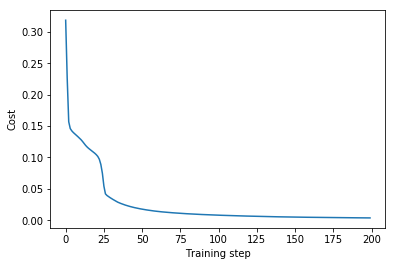

In [19]:
alpha = 0.001 # learning rate
N_iterations = 200
J = np.zeros(N_iterations)

for i in range(N_iterations):
    ## 
    cache, outputs = compute_forward(x_train, theta_matrices)
    J[i] = compute_cost(outputs, y_train_onehot)
    theta_grad = compute_backprop(x_train, theta_matrices, cache, outputs, y_train_onehot)
    for layer in range(len(theta_matrices)):
        theta_matrices[layer] -= alpha * theta_grad['theta'+str(layer)]

# calculate the loss on the whole training set 
J_train = compute_cost(compute_forward(x_train, theta_matrices)[1], y_train_onehot)
print('training cost: %f' %J_train)

# plot cost function
plt.plot(J)
plt.xlabel('Training step')
plt.ylabel('Cost')
plt.show()

## Step 5: Evaluation

In [20]:
def compute_accuracy(y_ground_truth,y_pred):
    ### YOUR CODE GOES  HERE ###
    return np.mean(y_ground_truth == y_pred)

pred_one_max = compute_forward(x_test, theta_matrices)[1]
pred = np.argmax(pred_one_max, axis=1)
# Your prediction would be an one-hot vector, for each test sample, select the one with the highest probablity to assign the class
accuracy = compute_accuracy(y_test, pred)
print('accuracy: ', accuracy)

accuracy:  0.8729281767955801
